In [1]:
from video699.video.annotated import get_videos
from bs4 import BeautifulSoup
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import cv2
from shutil import copyfile

In [2]:
videos = get_videos()
videos = [Path(videos[video].pathname) for video in videos.keys()]

In [3]:
path = Path('/mnt/c/Users/mikul/Desktop/BP/implementation-system/video699/video/annotated/semantic_segmentation_dataset')
path_img = path/'images'
path_lbl = path/'labels'

In [4]:
fnames = [image for video in videos for image in get_image_files(video) if 'frame' in image.name]

In [5]:
new_fnames = [fname.parent.parent/'semantic_segmentation_dataset'/'images'/f"{fname.parent.stem}_{fname.name}" for fname in fnames]

In [6]:
def move_images(fnames, new_fnames):
    for src, dst in zip(fnames, new_fnames):
        copyfile(src, dst)
        
move_images(fnames, new_fnames)

In [7]:
mask_gray=None

def create_labels(videos):
    for video in videos:
        record = video/'record.xml'
        with open(record, mode='r') as file:
            xml = file.read()
            soup = BeautifulSoup(xml, 'xml')
            width, height = int(soup.find('video')['width']), int(soup.find('video')['height'])

            for frame in soup.find_all('frame'):
                filename = frame['filename']
                mask = np.zeros((height, width, 3), dtype=np.uint8)
                for screen in frame.find_all('screen'):
                    # OpenCv convention down right corner first means x3 before x2
                    xs = map(int, (screen['x0'], screen['x1'], screen['x3'], screen['x2']))
                    ys = map(int, (screen['y0'], screen['y1'], screen['y3'], screen['y2']))
                    cv2.fillConvexPoly(mask, np.array([[[xi, yi]] for xi, yi in zip(xs, ys)]).astype(np.int32),
                                       (1, 1, 1))
                mask_gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
                label_name = str(video.parent/'semantic_segmentation_dataset'/'labels'/f'{video.stem}_{filename}')
                cv2.imwrite(label_name, mask_gray)

In [8]:
create_labels(videos)

In [9]:
fnames = get_image_files(path_img)
flabels = get_image_files(path_lbl)

In [10]:
get_label_from_image_name = lambda x: path_lbl/x.name

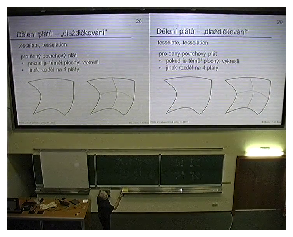

In [11]:
img_f = fnames[229]
img = open_image(img_f)
img.show(figsize=(5,5))

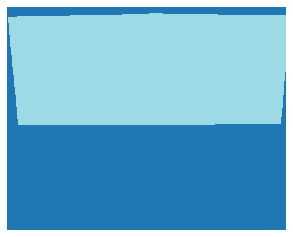

In [12]:
label_img_path = get_label_from_image_name(img_f)
img = open_mask(label_img_path)
img.show(figsize=(5,5), alpha=1)